# TDT4173 - Machine Learning
## Final Notebook of project


Students: TESTARD Arthur, VERDON Valentin and VERDIER Nahel

## Contents

0. Imports and variable initialization
1. Data analysis
    - Size analysis, data type, number of features, split into data categories
    - NAN analysis
    - Correlatiosn analysis 
    - #Analyse avec le reshaped

2. Research leads
    - Signal analysis 
    - Signal treatment model with filter and correlations with noises -> Prophet
    - AutoML (keras)
    - #Analyse de la linéarité entre les entrées/sortie
    - #Mettre une étape pour réguler les données simulées par rapport aux données observées 

3. Preprocessing: 
    - Columns selection
    - NANs management
    - Columns creation
    - Normalizations (StandardScaler, Normalizer, RobustScaler, MinMaxScaler)
    - Train/Test split
    - décaler les dates de sortie / entrée (si j’ai le temps diff x_t et x_t-1 pour prédire y_t)

4. Model XGBoost: 
    - Different models testing (RandomForest / LinearRegressor)
    - Hyperparameters study
    - Features importance


## 0. Imports and data initialization

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
# import networkx as nx
import scipy
import pickle

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
# from sklearn.preprocessing import StandardScaler

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
class DataFolder:
    def __init__(self, folder_name: str):
        self.folder_name: str
        self.X_test_estimated: str = f"{folder_name}/X_test_estimated.parquet"
        self.X_train_estimated: str = f"{folder_name}/X_train_estimated.parquet"
        self.X_train_observed: str = f"{folder_name}/X_train_observed.parquet"
        self.train_targets: str | None = f"{folder_name}/train_targets.parquet"

A = DataFolder(folder_name='A')
B = DataFolder(folder_name='B')
C = DataFolder(folder_name='C')

In [3]:
def read_files(diff_path: str = ''):
    train_a = pd.read_parquet(diff_path + A.train_targets)
    train_b = pd.read_parquet(diff_path + B.train_targets)
    train_c = pd.read_parquet(diff_path + C.train_targets)

    X_train_estimated_a = pd.read_parquet(diff_path + A.X_train_estimated)
    X_train_estimated_b = pd.read_parquet(diff_path + B.X_train_estimated)
    X_train_estimated_c = pd.read_parquet(diff_path + C.X_train_estimated)

    X_train_observed_a = pd.read_parquet(diff_path + A.X_train_observed)
    X_train_observed_b = pd.read_parquet(diff_path + B.X_train_observed)
    X_train_observed_c = pd.read_parquet(diff_path + C.X_train_observed)

    X_test_estimated_a = pd.read_parquet(diff_path + A.X_test_estimated)
    X_test_estimated_b = pd.read_parquet(diff_path + B.X_test_estimated)
    X_test_estimated_c = pd.read_parquet(diff_path + C.X_test_estimated)

    return train_a, train_b, train_c, X_train_estimated_a, X_train_estimated_b, X_train_estimated_c, X_train_observed_a, X_train_observed_b, X_train_observed_c, X_test_estimated_a, X_test_estimated_b, X_test_estimated_c

## 1. Data analysis

## 2. Research leads

### 1. Signal analysis

Because our data were presenting some periodicities, intuitively, one of our first idea were to analyse the different signals we have, starting by our target, `pv_measurement`. However, as we can see on the following plot, the data is not completly cleared, specially on B and C. We will come back to this point in Preprocessing part.

In [4]:
train_a, train_b, train_c, X_train_estimated_a, X_train_estimated_b, X_train_estimated_c, X_train_observed_a, X_train_observed_b, X_train_observed_c, X_test_estimated_a, X_test_estimated_b, X_test_estimated_c = read_files()

<Axes: title={'center': 'pv_measurement on location C'}, xlabel='time'>

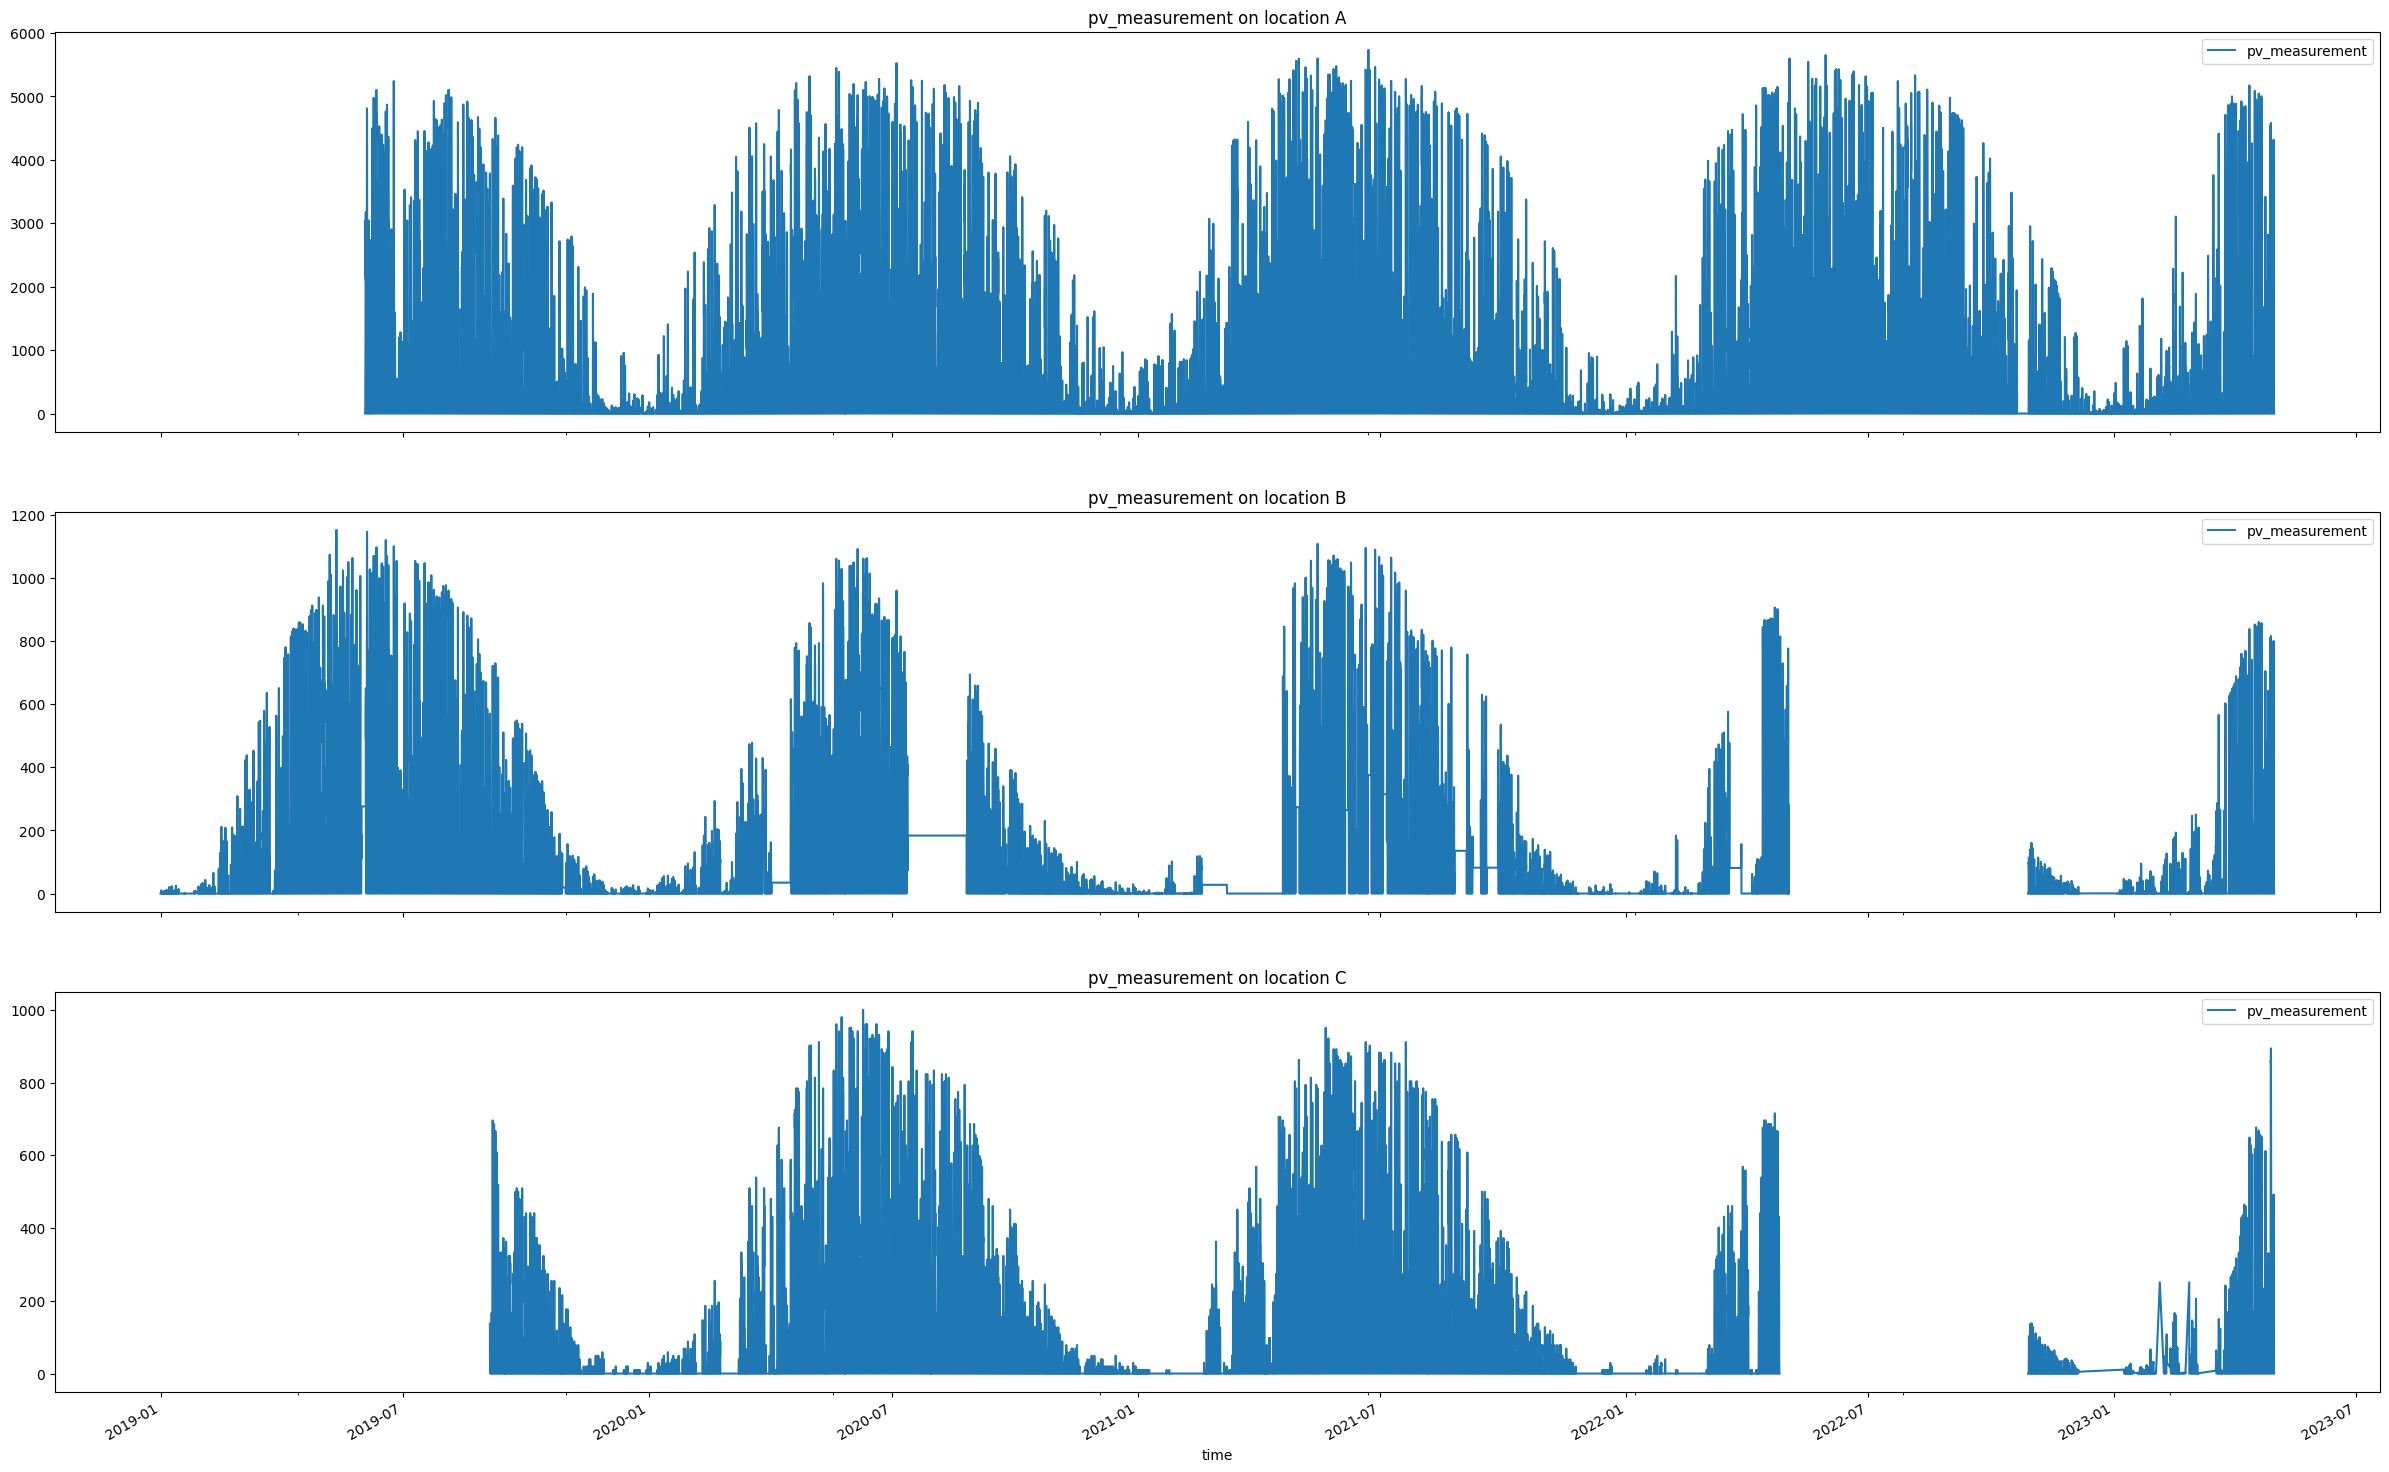

In [5]:
fig, axs = plt.subplots(3, 1, figsize=(30, 20), sharex=True)

train_a[['time','pv_measurement']].set_index('time').plot(ax=axs[0], title='pv_measurement on location A')
train_b[['time','pv_measurement']].set_index('time').plot(ax=axs[1], title='pv_measurement on location B')
train_c[['time','pv_measurement']].set_index('time').plot(ax=axs[2], title='pv_measurement on location C')

As we said, we then tryied to analys this signal with basic components such as Fourier analysis.

In [6]:
def get_fft_transforms(train):
    y = train["pv_measurement"].dropna().values
    time_diff = train["time"].diff().mean().total_seconds()
    sampling_rate = 1 / time_diff

    n = len(y)
    freq = np.fft.fftfreq(n, 1 / sampling_rate)
    fft_y = np.fft.fft(y)
    amp_fft_y = np.abs(fft_y)
    phase = np.angle(fft_y)
    return freq, fft_y, amp_fft_y, phase, sampling_rate

In [7]:
trains = { 'A': train_a, 'B': train_b, 'C': train_c }
locations = trains.keys()

freqs, fft_ys, amp_fft_ys, phases, sampling_rates = [
    { 
        loc: get_fft_transforms(trains[loc])[k] for loc in locations 
    } 
    for k in range(5)]

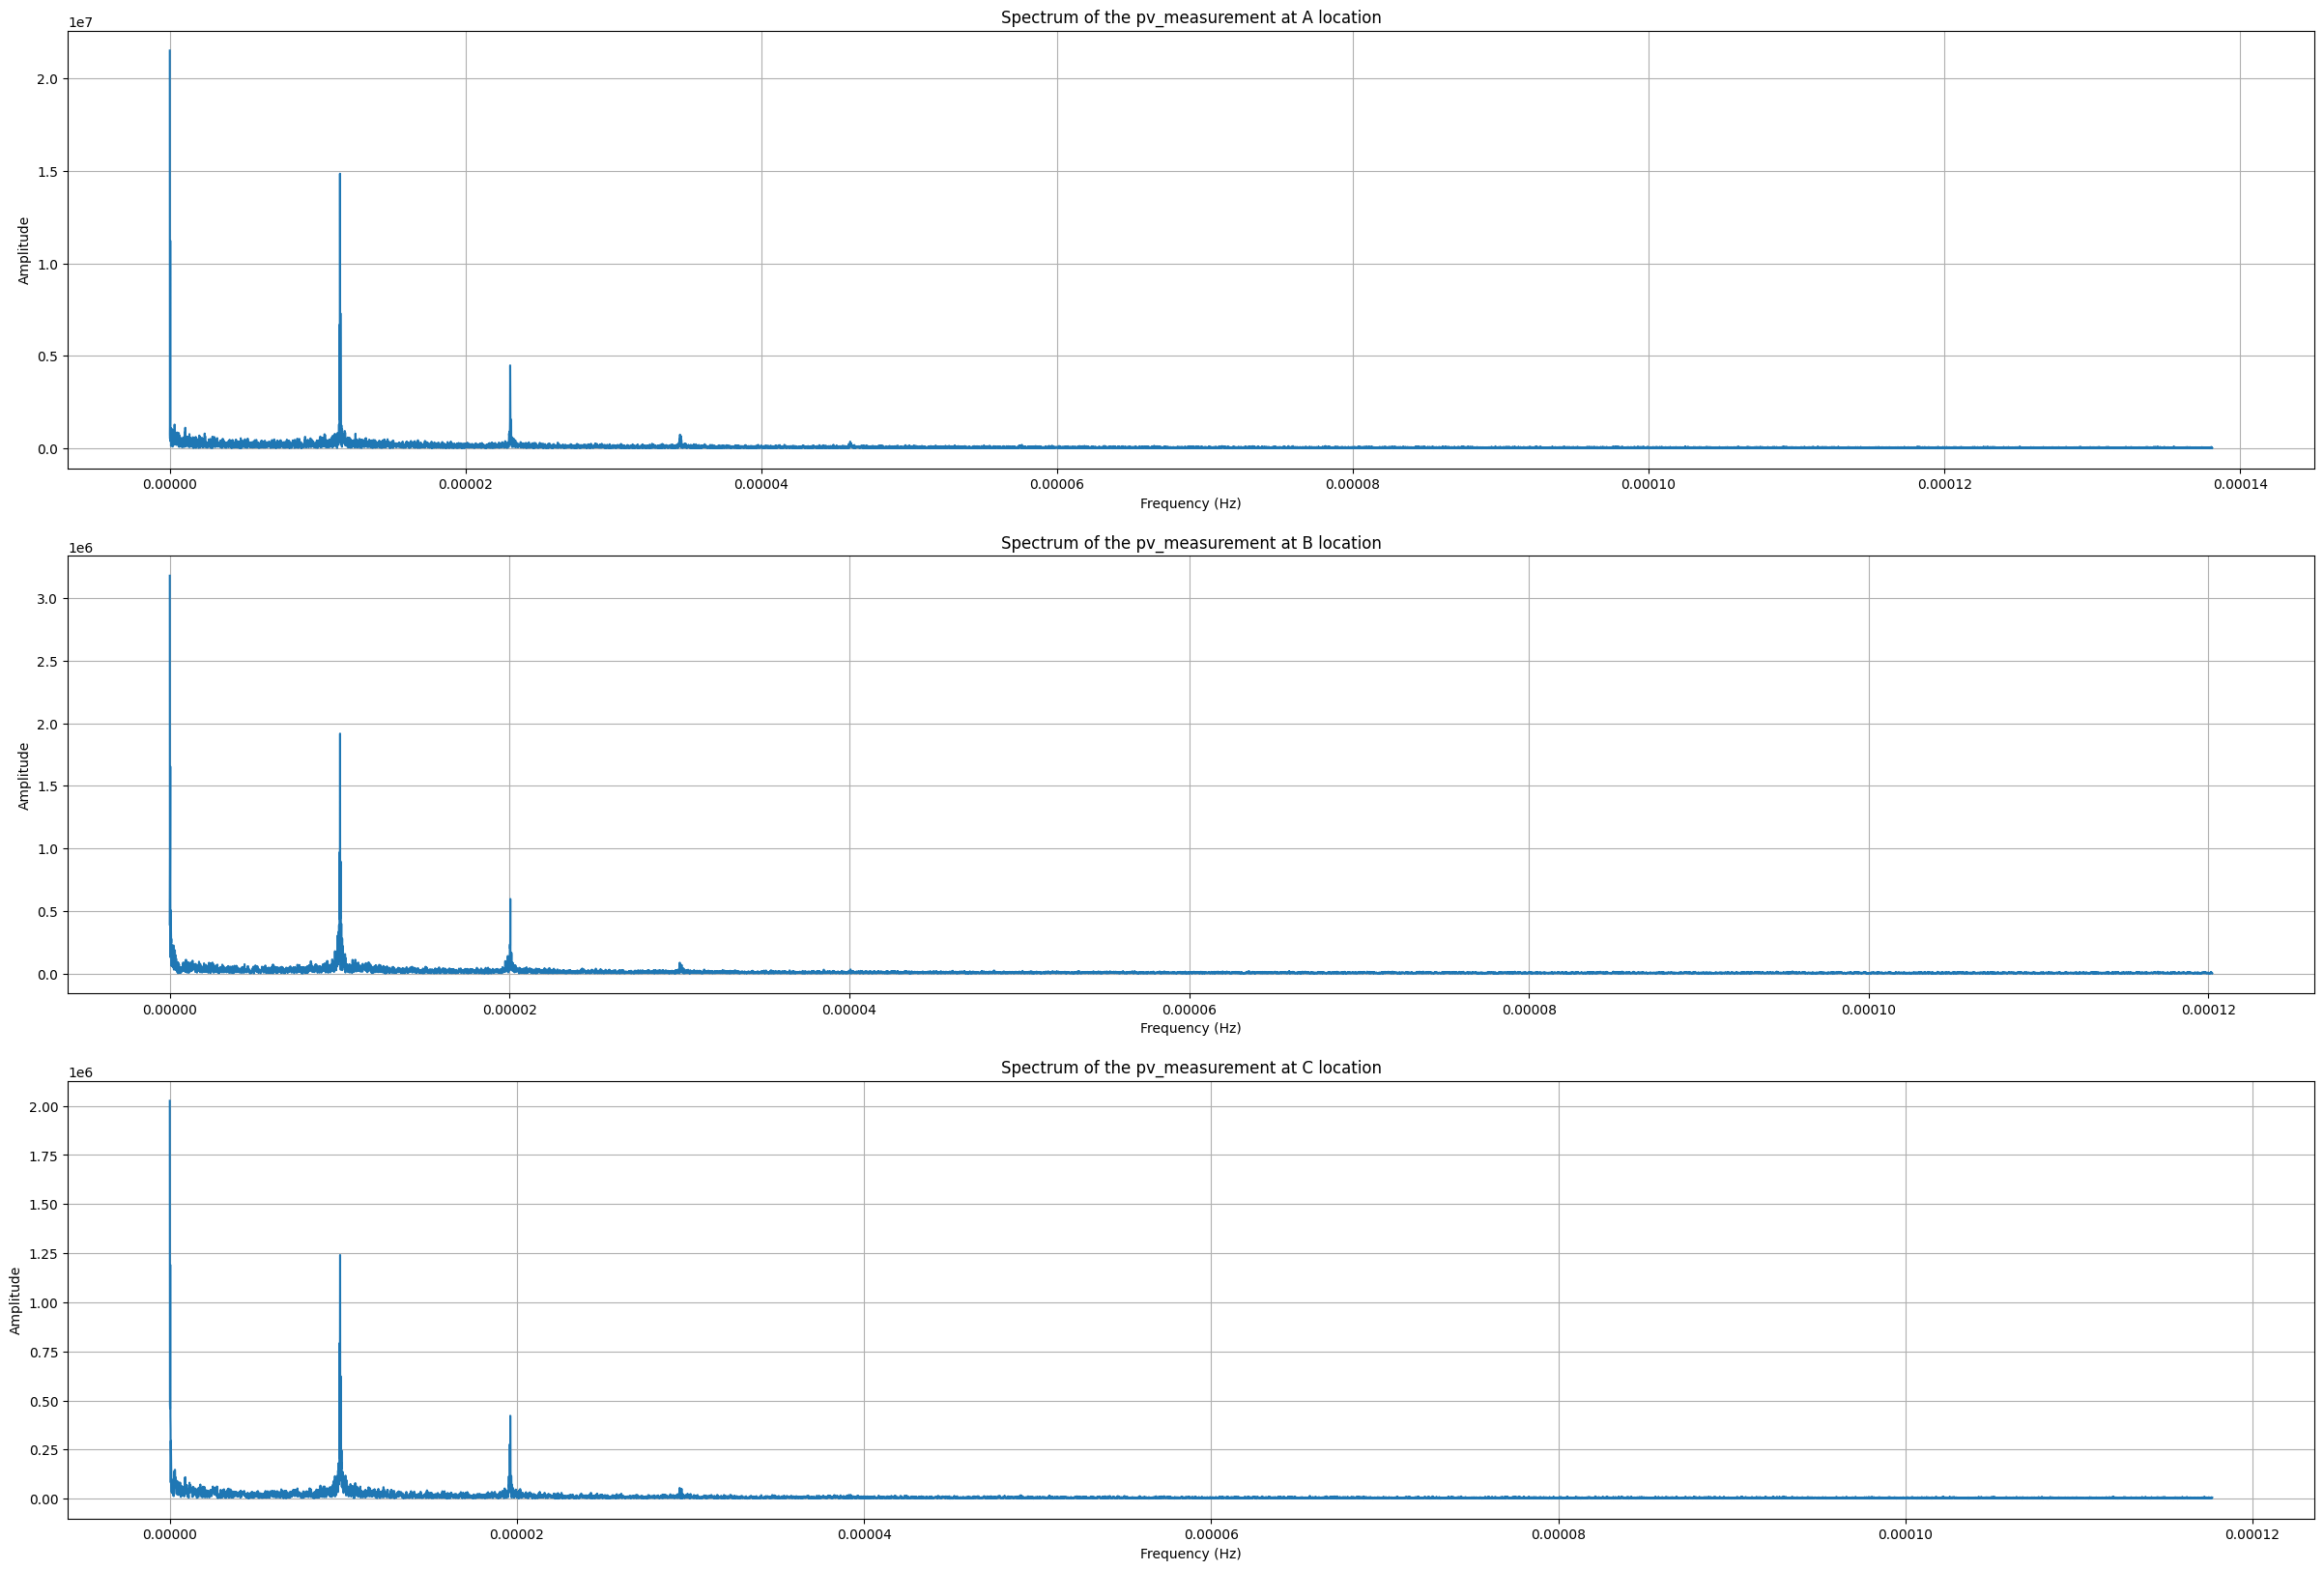

In [8]:
plt.figure(figsize=(30, 20))
k = 1
for loc in locations:
    plt.subplot(3, 1, k)
    plt.plot(freqs[loc][:len(freqs[loc])//2], amp_fft_ys[loc][:len(freqs[loc])//2])
    plt.title(f"Spectrum of the pv_measurement at {loc} location")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.grid()
    k += 1
plt.show()

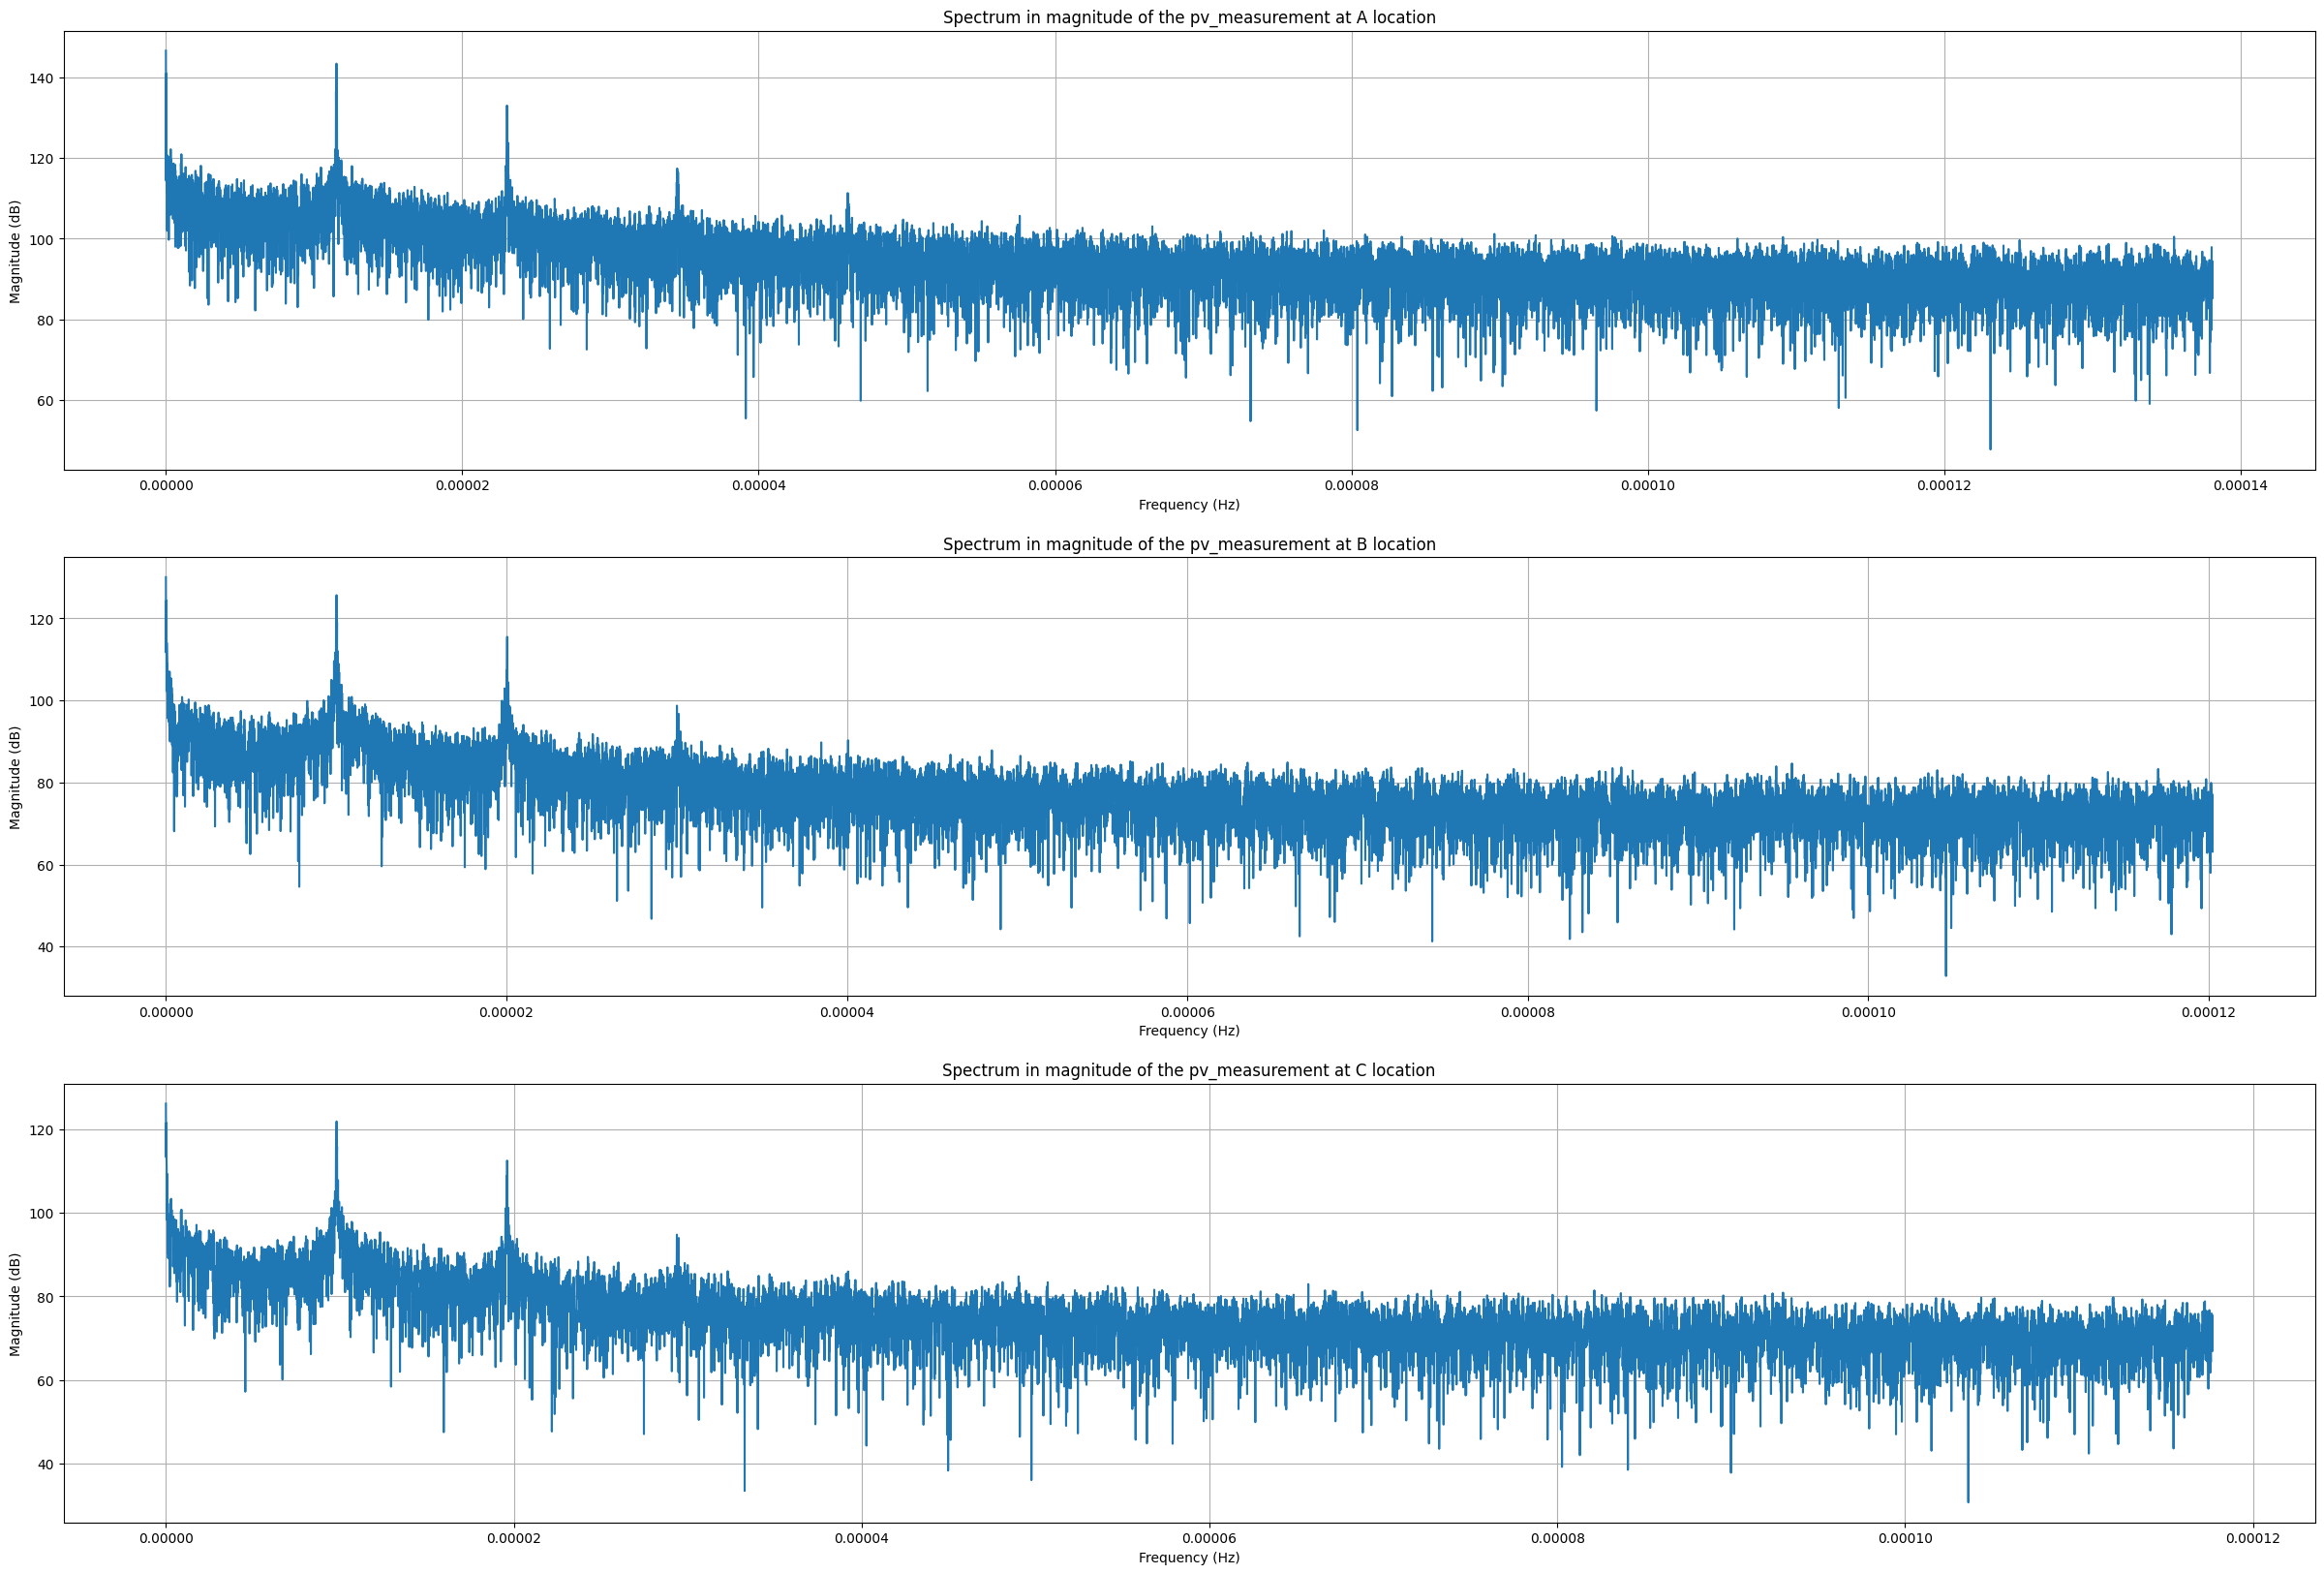

In [9]:
plt.figure(figsize=(30, 20))
k = 1
for loc in locations:
    plt.subplot(3, 1, k)
    plt.plot(freqs[loc][:len(freqs[loc])//2], 20 * np.log10(amp_fft_ys[loc][:len(freqs[loc])//2]))
    plt.title(f"Spectrum in magnitude of the pv_measurement at {loc} location")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.grid()
    k += 1
plt.show()

We then looked on the most important frequencies in those spectrums.

In [10]:
def print_peak_frequencies(amp_fft_y, freq, threshold, loc):
    peaks, _ = scipy.signal.find_peaks(amp_fft_y[:len(amp_fft_y)//2], height=threshold)
    peak_frequencies = freq[:len(freq)//2][peaks]

    period_size = int(1/peak_frequencies[0])
    continuous_component = np.mean(trains[loc]["pv_measurement"].dropna().values[:period_size])

    print("Location:", loc)
    print(f'Most important periods (in days): \n{1 / peak_frequencies / 3600 / 24}')
    print(f'Value of the continous component: {continuous_component}\n\n')

In [11]:
thresholds = { 'A': .5e7, 'B': .5e6, 'C': .25e6 }
for loc in locations:
    print_peak_frequencies(amp_fft_ys[loc], freqs[loc], thresholds[loc], loc)

Location: A
Most important periods (in days): 
[357.02089102   1.00853359   1.00569265   1.00286767]
Value of the continous component: 630.5947070558896


Location: B
Most important periods (in days): 
[395.21390076 225.83651472   1.15813597   1.15475208   1.15138791
   0.57737604]
Value of the continous component: 96.8247782508807


Location: C
Most important periods (in days): 
[427.693755   183.29732357   1.18256338   1.17930263   1.17605982
   0.59073723   0.58992242]
Value of the continous component: 77.63105958995978




First commentaries:

We know from the analysis of the nan values that A got the most clean datas in term of `pv_measurement` values. So our analysis will mostly be based on what we see on A. We can notice 3 most important frequencies: one for the year, one for the day and one for a half-day (12 hours). If we look more on the frequency plot, we can notice a most little one frequency (that our threshold impeach us to read it on the last print). This seems to be a peak for a period of 8 hours, according to the code cell bellow.

Because B and C are not much clean, we can suppose that the big differencies we found with A comes from the Nan values, which create some empty cells in these frames, which are compensated by increasing the frequency values. However, we did not pay attention to it much at first be because most of our analysis were based on A data.

In [12]:
freq_a_1 = np.min(np.where(freqs['A'] > .00003)) 
freq_a_2 = np.max(np.where(freqs['A'] < .00004))
freq_arg = np.argmax(fft_ys['A'][:len(fft_ys['A'])//2][freq_a_1:freq_a_2])
1 / freqs['A'][:len(fft_ys['A'])//2][freq_a_1:freq_a_2][freq_arg] / 3600 

8.037993794156831

We can confirm what we sayied on B and C compared to A if we look on the differents sampling rates depending on the situation. Theorically, it should be close to one hour ($=3600$ seconds) because our values are measured every hours. But if we look on `1 / sampling_rates['B']` and `1 / sampling_rates['C']` we see that it's more than it for B and C locations. This comes from Nan values and confirms our point above.

We can notice that `1 / sampling_rates['B']` is a bit bigger than an hour. We can explain it by the gap of one week between `X_train_observed_a` and `X_train_estimated_a`, which exists as well in `train_a`.

In [13]:
1 / sampling_rates['A'] / 3600, 1 / sampling_rates['B'] / 3600, 1 / sampling_rates['C'] / 3600

(1.005545123611111, 1.1551739883333334, 1.1800709086111112)

The first thing we can try is to recalculate the model by the inverse of Fourier's transformation.

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


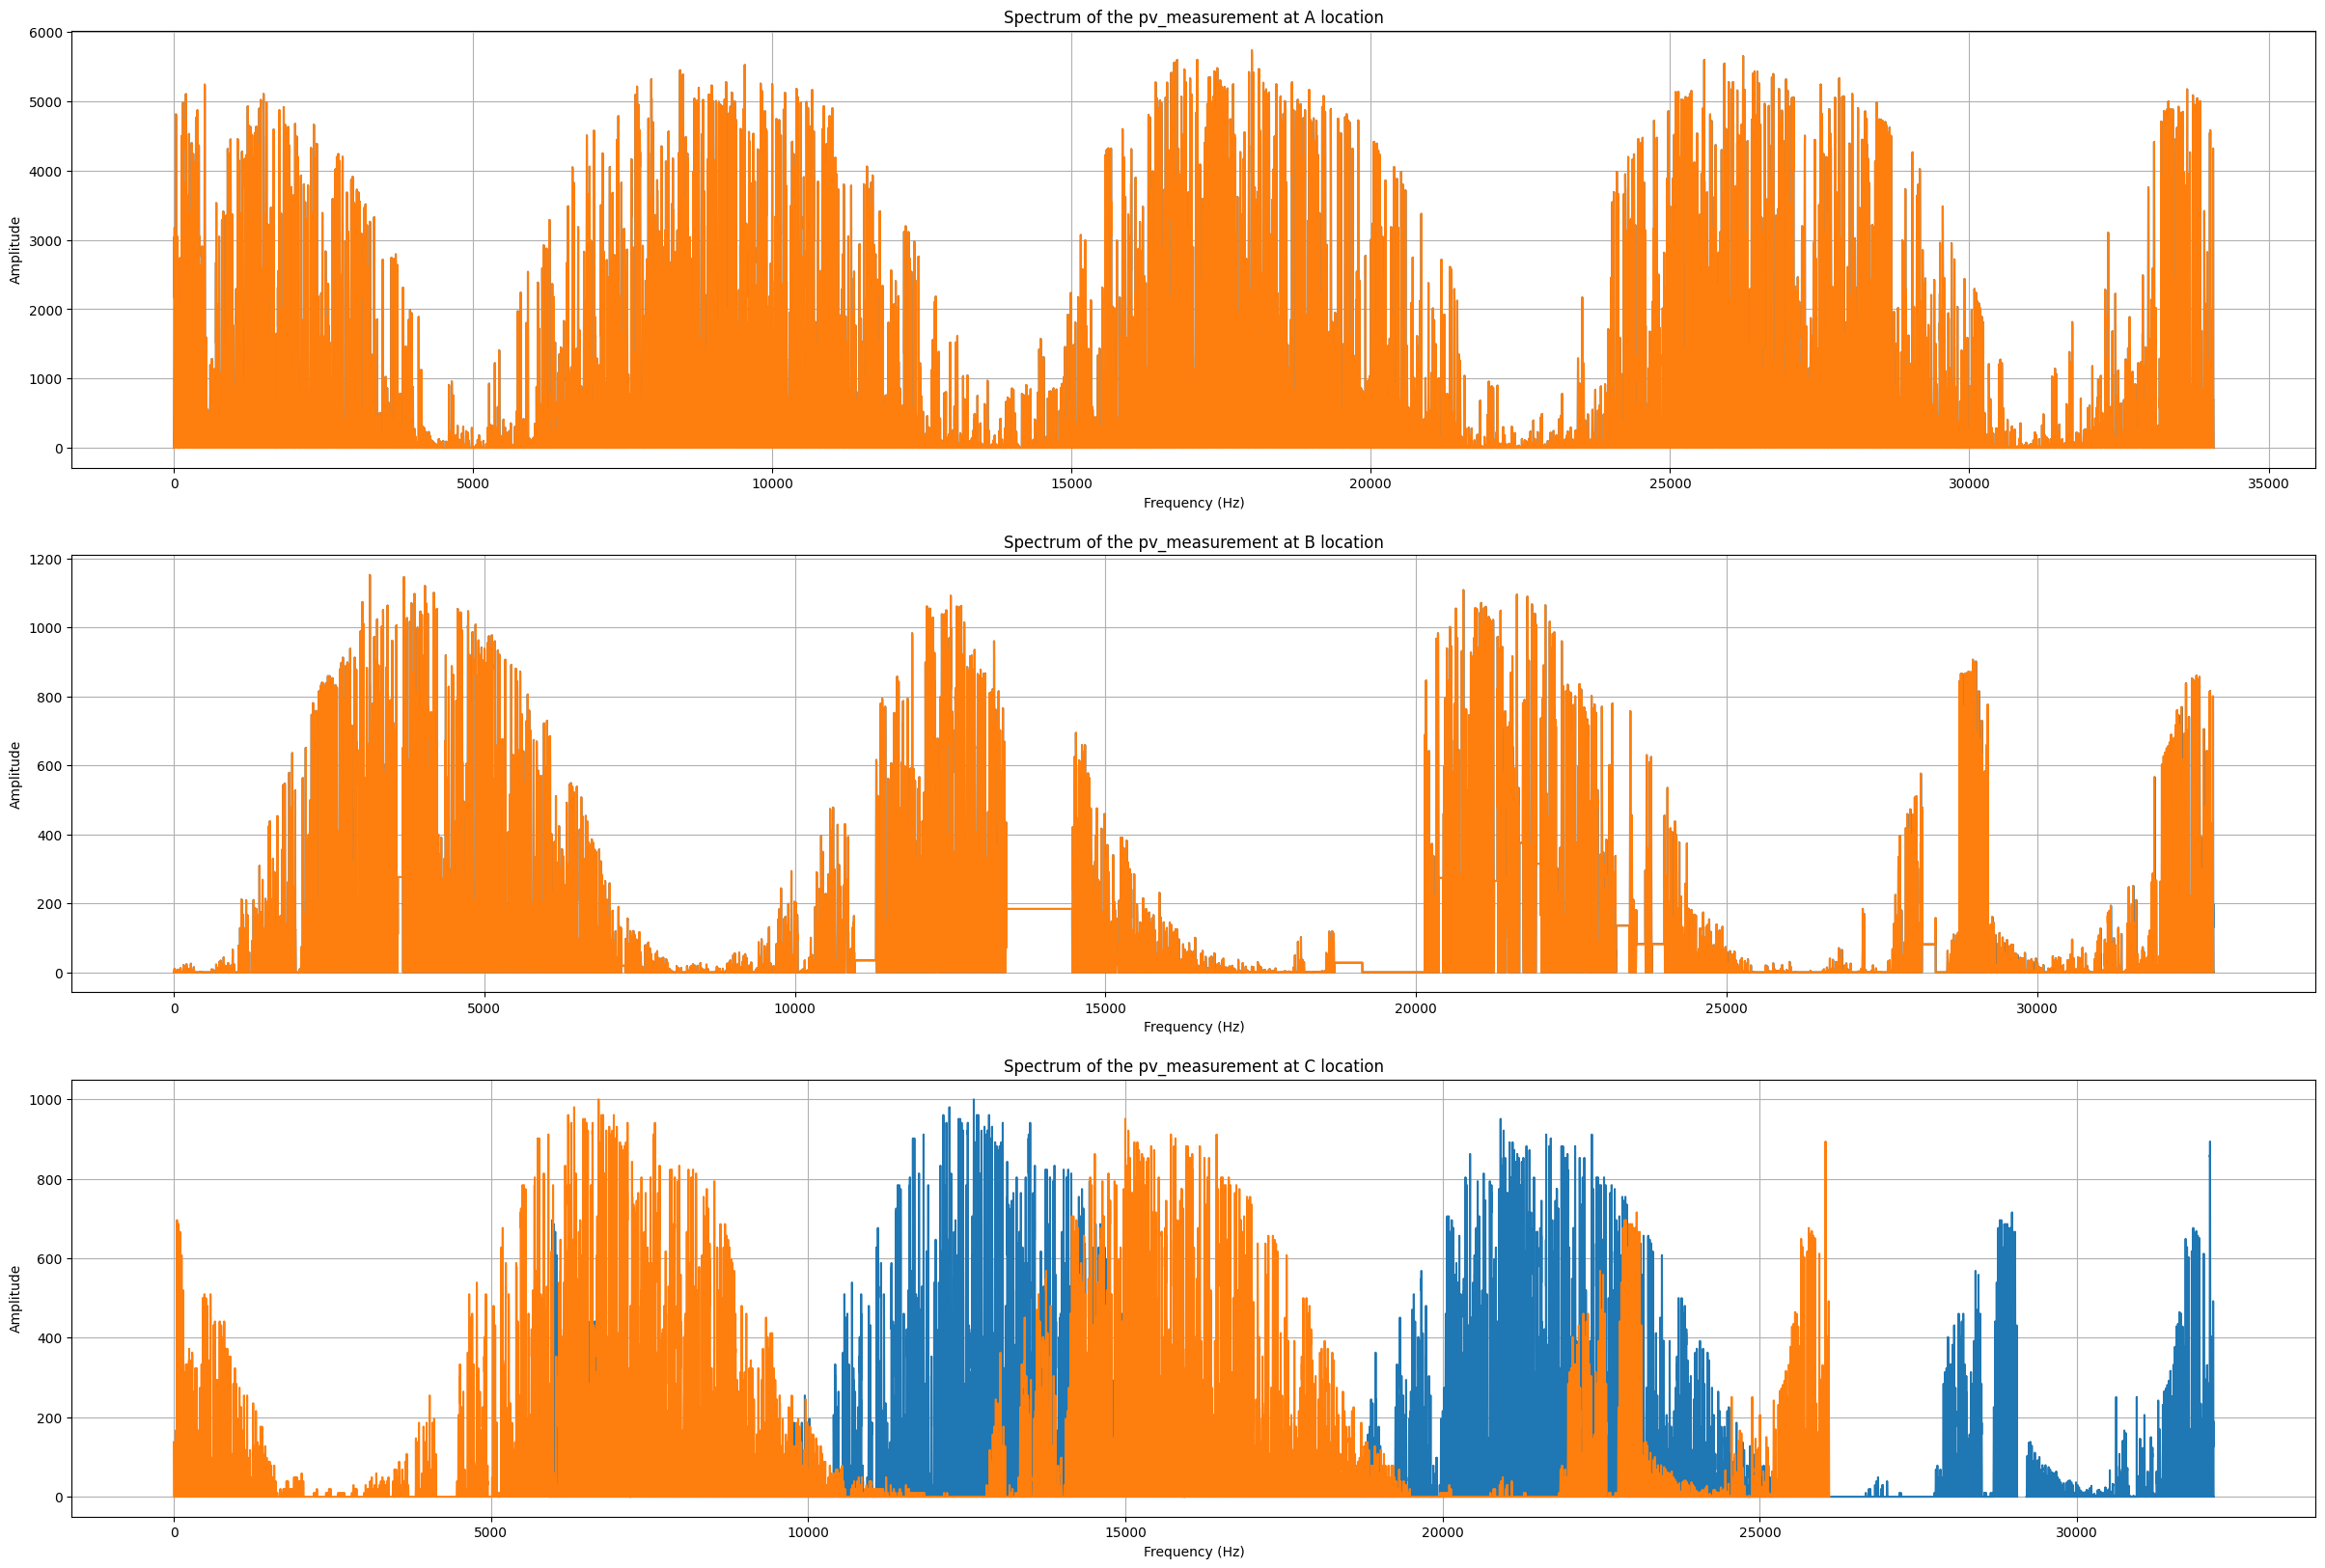

In [14]:
i_fft_ys = { loc: np.fft.ifft(fft_ys[loc]) for loc in locations }

plt.figure(figsize=(30, 20))
k = 1
for loc in locations:
    plt.subplot(3, 1, k)
    plt.plot(trains[loc]['pv_measurement'], label='real pv_measurement')
    plt.plot(i_fft_ys[loc], label='ifft pv_measurement')
    plt.title(f"Spectrum of the pv_measurement at {loc} location")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.grid()
    k += 1
plt.show()

We notice a gap created in C but in facts its due to the index. 

Now the idea is to keep only the most important frequencies in order to have a model which can be written like this:
$$y[n] = \hat{y}[n] + r[n]$$

where $n$ is the index of the output, $y[n]$ is the real value of `pv_measurement` at index $n$ (or time $t$), $\hat{y}[n]$ is the value at index $n$ of the signal filtered predicted by signal analysis and $r[n]$ is the value at index $n$ of the noise created by mostly, the weather, from our inputs `X_train_estimated`, `X_train_observed`, etc. It would be design by a machine learning model. Actually we did not had the time to test this feature entirely, because of a lack of time our goals priotization. So, it is not entirely designed, but we will detail as far as we came to it.

However, we explored different ways to design $\hat{y}[n]$. The first one is a raw filter on the whole signal. This method were not much efficient. In our researchs we found `prophet`, a Python (and R) library which gives a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

In [16]:
trains_prophet = { loc: trains[loc].rename(columns={'time': 'ds', 'pv_measurement': 'y'})[:29667] for loc in locations}

models_prophet = { loc: Prophet(changepoint_prior_scale=0.05) for loc in locations }
predictions_prophet = {}
forecast = {}
for loc in locations:
    models_prophet[loc].fit(trains_prophet[loc])
    predictions_prophet[loc] = models_prophet[loc].make_future_dataframe(periods=66, freq='h')
    forecast[loc] = models_prophet[loc].predict(predictions_prophet[loc])
    predictions_prophet[loc].plot(forecast[loc]) 

16:01:22 - cmdstanpy - INFO - Chain [1] start processing
16:01:26 - cmdstanpy - INFO - Chain [1] done processing


ValueError: Boolean array expected for the condition, not datetime64[ns]

This results, from prophet and the filter signal, are not really satisfying. Then came the idea, inpired by [this paper](https://peerj.com/preprints/3190.pdf), to see what's happen if we plot one signal for each hour (it would make $24 * 3 = 72$ models). We then first split our signals by hours and plot what we get with prophet prediction and our filter.

In [ ]:
# USEFULL VALUES TO COMPILE

hours = [ f"0{h}" if h < 10 else str(h) for h in range(24) ]

end_date = { 'a': '2022-10-21', 'b': '2022-03-15', 'c': '2022-04-01'}
start_date = { 'a': '2020-10-21', 'b': '2020-03-15', 'c': '2020-04-01' }

SyntaxError: invalid syntax (1864647108.py, line 6)

In [ ]:
trains_renamed = { locations[loc]: trains[loc].rename(columns={'time': 'ds', 'pv_measurement': 'y'}) for loc in locations}
trains_on_dates = { loc: trains_renamed[loc][(train_[loc]["ds"] < end_date[loc]) & (train_[loc]["ds"] > start_date[loc])] for loc in locations }

# MAYBE DROP NA ON B AND C
Y_train_by_hours = { loc: { h: trains_on_dates[loc][trains_on_dates[loc]['ds'].dt.strftime('%H:%M:%S').str.endswith(f'{h}:00:00')] for h in hours } for loc in locations }


## 3. Preprocessing

## 4. Model XGBoost